# MCMC Introduction

by Jason Wang and Henry Ngo (2018)

Here, we will explain how to sample an orbit posterior using MCMC techniques. MCMC samplers take some time
to fully converge on the complex posterior, but should be able to explore all posteriors in roughly the same
amount of time (unlike OFTI). We will use the parallel-tempered version of the Affine-invariant sample from
the `ptemcee` package, as the parallel tempering helps the walkers get out of local minima. Parallel-tempering can
be disabled by setting the number of temperatures to 1, and will revert back to using the regular ensemble 
sampler from emcee. 

## Read in Data and Set up Sampler

We use `orbitize.driver.Driver` to streamline the processes of reading in data, setting up the two-body interaction, and setting up the MCMC sampler.

When setting up the sampler, we need to decide how many temperatures and how many walkers per temperature
to use. Increasing the number of temperatures further ensures your walkers will explore all of parameter space
and will not get stuck in local minima. Increasing the number of walkers gives you more samples to use, and, for
the Affine-invariant sampler, a minimum number is required for good convergence. Of course, the tradeoff is that
more samplers means more computation time. We find 20 temperatures and 1000 walkers to be reliable for convergence. Since this is a tutorial meant to be run quickly, we use fewer walkers and temperatures here.

Note that we will only use the samples from the lowest-temperature walkers. We also assume that our astrometric measurements follow a Gaussian distribution.

`orbitize` can also fit for the total mass of the system and system parallax, including marginalizing over the uncertainties in those parameters.

In [1]:
import numpy as np

import orbitize
from orbitize import driver
import multiprocessing as mp

filename = "{}/GJ504.csv".format(orbitize.DATADIR)

# system parameters
num_secondary_bodies = 1
total_mass = 1.75  # [Msol]
plx = 51.44  # [mas]
mass_err = 0.05  # [Msol]
plx_err = 0.12  # [mas]

# MCMC parameters
num_temps = 5
num_walkers = 20
num_threads = 2  # or a different number if you prefer, mp.cpu_count() for example


my_driver = driver.Driver(
    filename,
    "MCMC",
    num_secondary_bodies,
    total_mass,
    plx,
    mass_err=mass_err,
    plx_err=plx_err,
    mcmc_kwargs={
        "num_temps": num_temps,
        "num_walkers": num_walkers,
        "num_threads": num_threads,
    },
)

## Running the MCMC Sampler

We need to pick how many steps the MCMC sampler should sample. Additionally, because the samples are correlated,
we often only save every nth sample. This helps when we run a lot of samples, because saving all the samples requires
too much disk space and many samples are unnecessary because they are correlated.

In [2]:
total_orbits = 6000  # number of steps x number of walkers (at lowest temperature)
burn_steps = 10  # steps to burn in per walker
thin = 2  # only save every 2nd step

my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/mnt/c/Users/Research/Desktop/GradSchool/Thesis/PlanetObliquitiesCode/OrbitFitting/orbitize/orbitize/priors.py:463: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/mnt/c/Users/Research/Desktop/GradSchool/Thesis/PlanetObliquitiesCode/OrbitFitting/orbitize/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/mnt/c/Users/Research/Desktop/GradSchool/Thesis/PlanetObliquitiesCode/OrbitFitting/orbitize/orbitize/priors.py:354: RuntimeWarning: invalid value encountered in log
  lnprob = -np.log((element_array*normalizer))
/mnt/c/Users/Research/Desktop/GradSchool/Thesis/PlanetObliquitiesCode/OrbitFitting/orbitize/orbitize/priors.py:463: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


Starting Burn in
10/10 steps of burn-in complete
Burn in complete. Sampling posterior now.
300/300 steps completed
Run complete


After completing the samples, the `'run_sampler'` method also creates a `'Results'` object that can be accessed
with `'my_sampler.results'`.

## MCMC Convergence

We want our walkers to be "converged" before they accurately sample the full posterior of our fitted parameters. Formal proofs of MCMC convergence are difficult or impossible in some cases. Many tests of convergence are necesary but not sufficient proofs of convergence. Here, we provide some convience functions to help assess convergence, but we caution they are not foolproof. A more detailed description of convergence analysis for affine-invariant samples (which are the ones used in `orbitize!`) is available [in the `emcee` docs](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/). 

One of the primary ways we assess convergence for orbit fits for MCMC is the visual inspection of the chains. This is done by looking at some key parameters such as semi-major axis and eccentricity and plotting the value sampled for each chain as a function of step number. At the beginning, the ensemble of walkers is going to expand/contract/wiggle around to figure out where the posterior space is. Eventually, the walkers will appear to reach some "thermal equilibrium" beyond which the values sampled by the ensemble of walkers appear to not change with time. Below is how to use some built-in diagnostic functions for this. 

### Diagnostic Functions

The `Sampler` object also has two convenience functions to examine and modify the walkers in order to diagnose MCMC performance. Note that in this example we have not run things for long enough with enough walkers to actually see convergence, so this is merely a demo of the API. 

First, we can examine 5 randomly selected walkers for two parameters: semimajor axis and eccentricity. We expect 150 steps per walker since there were 6,000 orbits requested with 20 walkers, so that's 300 orbits per walker. However, we have thinned by a factor of 2, so there are 150 saved steps.

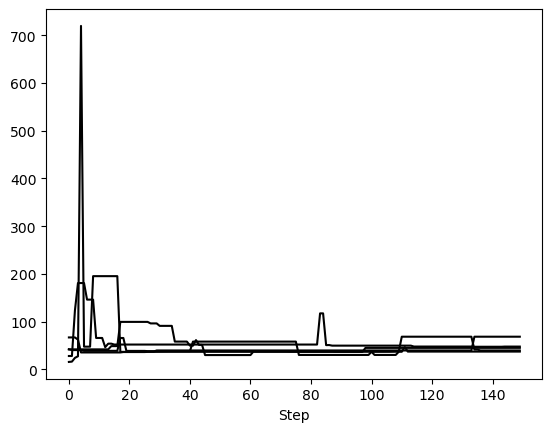

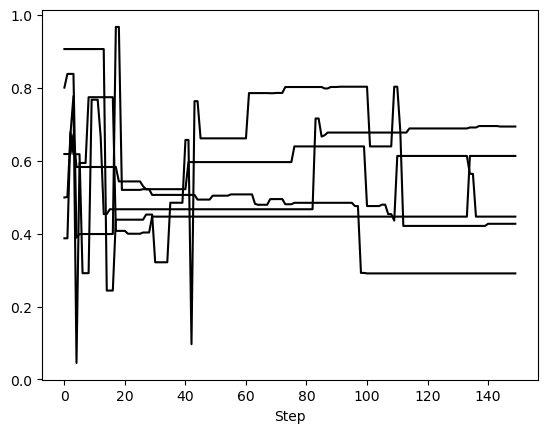

In [3]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(
    param_list=["sma1", "ecc1"], n_walkers=5
)

This method returns one matplotlib `Figure` object for each parameter. If no `param_list` given, all parameters are returned. Here, we told it to plot 5 randomly selected walkers but we could have specified exactly which walkers with the `walker_list` keyword. The `step_range` keyword also determines which steps in the chain are plotted (when nothing is given, the default is to plot all steps). We can also have these plots automatically generate if we called `run_sampler` with `examine_chains=True`.

Note that this is just a convenience function. It is possible to recreate these chains from reshaping the posterior samples and selecting the correct entries.

The second diagnostic tool is the `chop_chains`, which allows us to remove entries from the beginning and/or end of a chain. This updates the corresponding `Results` object stored in `sampler` (in this case, `my_driver.sampler.results`). The `burn` parameter specifies the number of steps to remove from the beginning (i.e. to add a burn-in to your chain) and the `trim` parameter specifies the number of steps to remove from the end. If only one parameter is given, it is assumed to be a `burn` value. If `trim` is not zero, the `sampler` object is also updated so that the current position (`sampler.curr_pos`) matches the new end point. This allows us to continue MCMC runs at the correct position, even if we have removed the last few steps of the chain.

Let's remove the first and last 25 steps, leaving 100 orbits (or steps) per walker

In [4]:
my_driver.sampler.chop_chains(burn=25, trim=25)

Chains successfully chopped. Results object updated.


Now we can examine the chains again to verify what we did. Note that the number of steps removed from either end of the chain is uniform across all walkers.

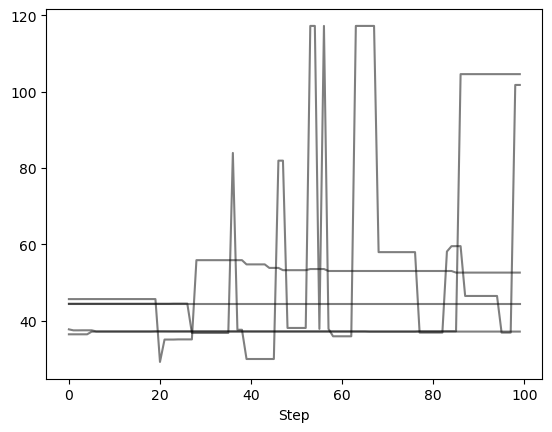

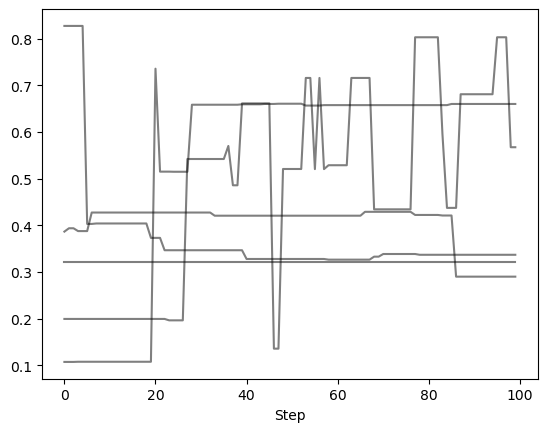

In [5]:
sma_chains, ecc_chains = my_driver.sampler.examine_chains(
    param_list=["sma1", "ecc1"], n_walkers=5, transparency=0.5
)

### Autocorrelation Time Estimation

We can use the `emcee` package to [estimate the autocorrelation time](https://emcee.readthedocs.io/en/stable/user/autocorr/) from our chains.

The integrated autocorrelation time ($\tau$) for each parameter is returned, with an estimate of $\sim$ 10-15 steps needed for the chain to "forget" where it started. Notice an `AutocorrError` is returned since we have not run our chain long enough. Therefore, we should treat the integrated autocorrelation time as a lower bound, and run the MCMC for more steps. [Here](https://github.com/dfm/emcee/blob/main/docs/tutorials/line.ipynb) is a tutorial from `emcee` that estimates a more accurate integrated autocorrelation time when the chains are properly converged.

In [6]:
import emcee

flatchain = my_driver.sampler.post
total_samples, n_params = flatchain.shape
n_steps = int(total_samples/num_walkers)
chn = flatchain.reshape(num_walkers, n_steps, n_params)
# For emcee, reshape to (n_steps, num_walkers, n_params)
chn = np.transpose(chn, axes=(1,0,2))

τ = emcee.autocorr.integrated_time(chn)
print(τ)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3;
tau: [ 9.13017815 12.34095536 11.6763064  11.86635329 13.02647509 11.60617003
 12.95939822 14.87615113]

## Plotting Basics

We will make some basic plots to visualize the samples in `'my_driver.sampler.results'`. Orbitize currently has two basic
plotting functions which return matplotlib `Figure` objects. First, we can make a corner plot (also known as
triangle plot, scatterplot matrix, or pairs plot) to visualize correlations between pairs of orbit parameters:

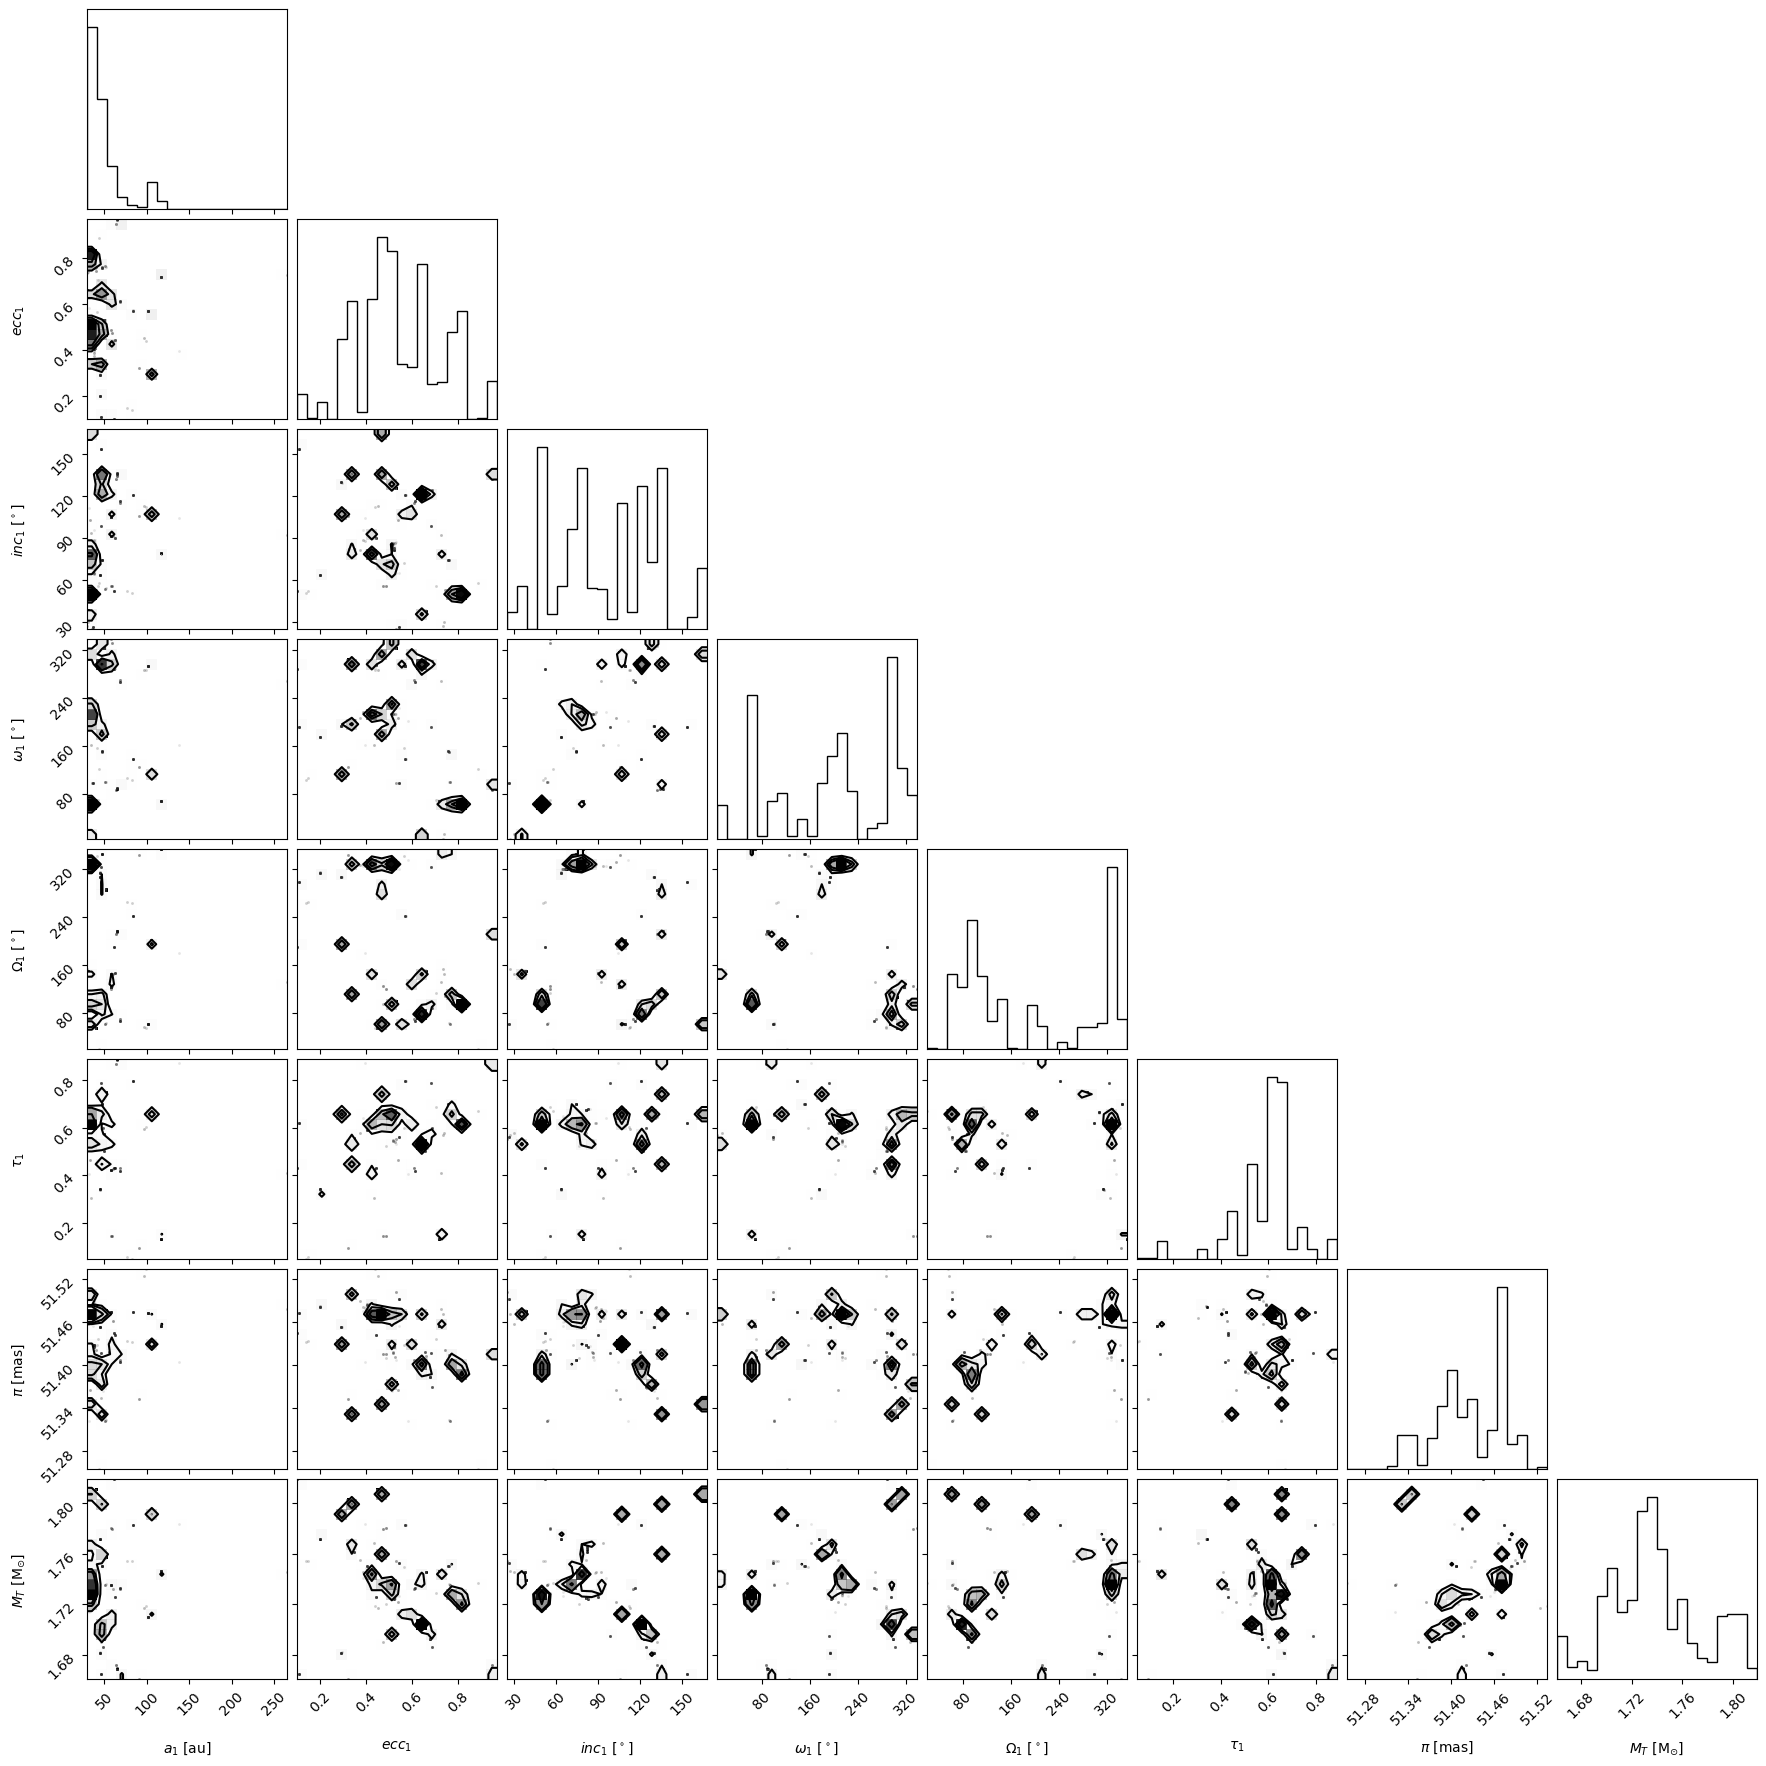

In [7]:
corner_plot_fig = (
    my_driver.sampler.results.plot_corner()
)  # Creates a corner plot and returns Figure object
corner_plot_fig.savefig(
    "my_corner_plot.png"
)  # This is matplotlib.figure.Figure.savefig()

Next, we can plot a visualization of a selection of orbits sampled by our sampler. By default, the first epoch
plotted is the year 2000 and 100 sampled orbits are displayed.

<Figure size 1400x600 with 0 Axes>

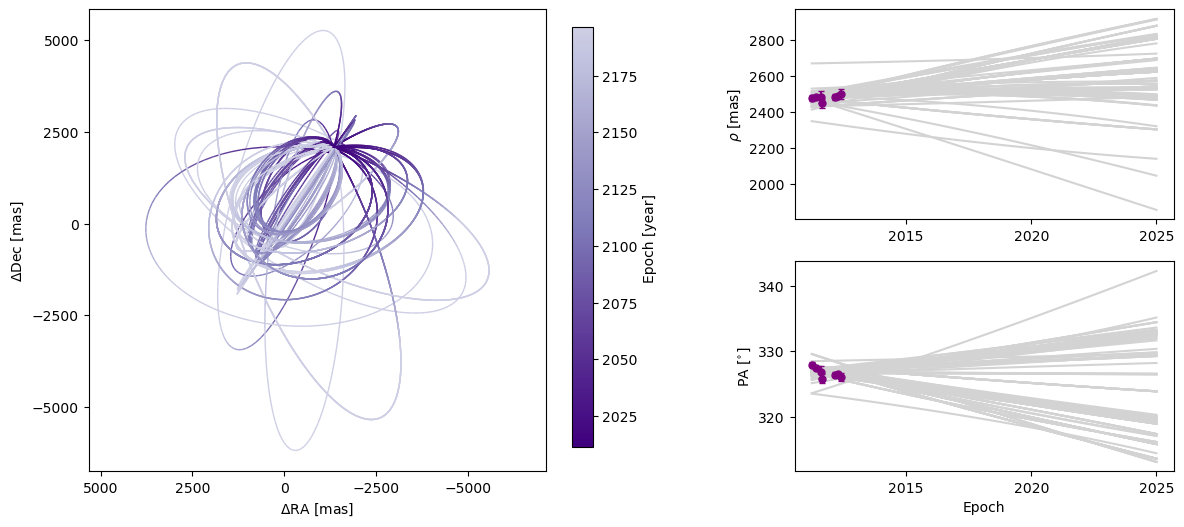

In [8]:
epochs = my_driver.system.data_table["epoch"]

orbit_plot_fig = my_driver.sampler.results.plot_orbits(
    object_to_plot=1,  # Plot orbits for the first (and only, in this case) companion
    num_orbits_to_plot=100,  # Will plot 100 randomly selected orbits of this companion
    start_mjd=epochs[0],  # Minimum MJD for colorbar (here we choose first data epoch)
)
orbit_plot_fig.savefig(
    "my_orbit_plot.png"
)  # This is matplotlib.figure.Figure.savefig()

For more advanced plotting options and suggestions on what to do with the returned matplotlib Figure objects,
see the dedicated Plotting tutorial.


## Saving and Loading Results

We will save the results in the HDF5 format. It will save two datasets: `'post'` which will contain the posterior
(the chains of the lowest temperature walkers) and `'lnlike'` which has the corresponding probabilities. In addition,
it saves `'sampler_name'` and the orbitize version number as attributes of the HDF5 root group, and the 
``orbitize.system.System`` object used to generate the orbit fit.

In [9]:
hdf5_filename = "my_posterior.hdf5"
import os

# To avoid weird behaviours, delete saved file if it already exists from a previous run of this notebook
if os.path.isfile(hdf5_filename):
    os.remove(hdf5_filename)
my_driver.sampler.results.save_results(hdf5_filename)

Saving sampler results is a good idea when we want to analyze the results in a different script or when we want to save the output of a long MCMC run to avoid having to re-run it in the future. We can then load the saved results into a new blank results object.

In [10]:
from orbitize import results

loaded_results = results.Results()  # Create blank results object for loading
loaded_results.load_results(hdf5_filename)

Instead of loading results into an orbitize.results.Results object, we can also directly access the saved data using
the `'h5py'` python module.

In [11]:
import h5py

filename = "my_posterior.hdf5"
hf = h5py.File(filename, "r")  # Opens file for reading
# Load up each dataset from hdf5 file
sampler_name = str(hf.attrs["sampler_name"])
post = np.array(hf.get("post"))
lnlike = np.array(hf.get("lnlike"))
hf.close()  # Don't forget to close the file